In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
df1 = pd.read_csv('movies.csv')
df1.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
import numpy as np

In [5]:
df_rat = df.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

In [6]:
df_rat.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from scipy.sparse import csr_matrix
mat_movie = csr_matrix(df_rat.values)

In [8]:
from sklearn.neighbors import NearestNeighbors

In [9]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors = 20, n_jobs = -1)

In [10]:
knn.fit(mat_movie)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [11]:
num_users = len(df.userId.unique())
num_items = len(df.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


In [12]:
df_ratings_cnt_tmp = pd.DataFrame(df.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [13]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [14]:
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

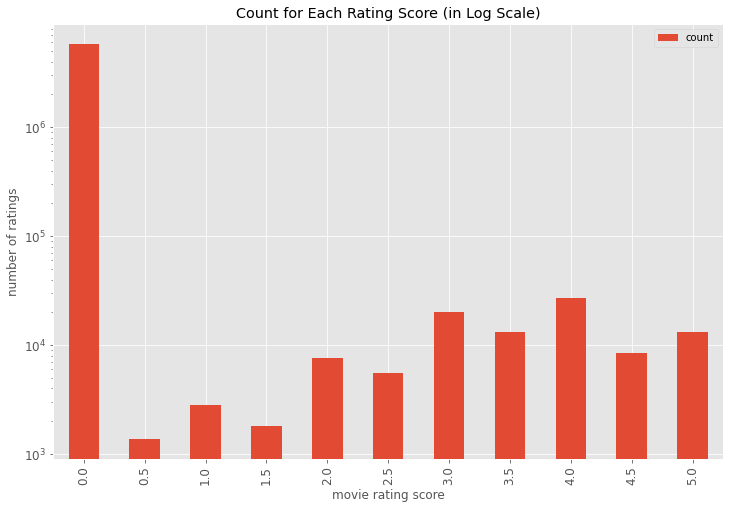

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")


In [16]:
df_movies_cnt = pd.DataFrame(df.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


In [17]:
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df[df.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping unpopular movies:  (41360, 4)


In [18]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


In [19]:
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 4)


In [20]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df1.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)


In [21]:
movie_user_mat_sparse

<450x268 sparse matrix of type '<class 'numpy.float64'>'
	with 32999 stored elements in Compressed Sparse Row format>

In [22]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [23]:
from fuzzywuzzy import fuzz

/home/ayush/.local/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
 
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [25]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))


In [26]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Batman Begins (2005), with distance of 0.34744154173084363
2: Sherlock Holmes (2009), with distance of 0.3463540530285869
3: Kung Fu Panda (2008), with distance of 0.34323498779508776
4: Inception (2010), with distance of 0.33073992134058794
5: District 9 (2009), with distance of 0.3187720802539473
6: Up (2009), with distance of 0.31706735090314886
7: WALL·E (2008), with distance of 0.27033112296383466
8: Avengers, The (2012), with distance of 0.2610290662950412
9: Avatar (2009), with distance of 0.2599024893009969
10: Dark Knight, The (2008), with distance of 0.24019004841992464


In [27]:
movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Heat (1995)': 3,
 'Sabrina (1995)': 4,
 'GoldenEye (1995)': 5,
 'American President, The (1995)': 6,
 'Casino (1995)': 7,
 'Sense and Sensibility (1995)': 8,
 'Ace Ventura: When Nature Calls (1995)': 9,
 'Get Shorty (1995)': 10,
 'Leaving Las Vegas (1995)': 11,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 12,
 'Babe (1995)': 13,
 'Dead Man Walking (1995)': 14,
 'Clueless (1995)': 15,
 'Seven (a.k.a. Se7en) (1995)': 16,
 'Pocahontas (1995)': 17,
 'Usual Suspects, The (1995)': 18,
 "Mr. Holland's Opus (1995)": 19,
 'From Dusk Till Dawn (1996)': 20,
 'Broken Arrow (1996)': 21,
 'Happy Gilmore (1996)': 22,
 'Braveheart (1995)': 23,
 'Taxi Driver (1976)': 24,
 'Birdcage, The (1996)': 25,
 'Bad Boys (1995)': 26,
 'Apollo 13 (1995)': 27,
 'Batman Forever (1995)': 28,
 'Casper (1995)': 29,
 'Congo (1995)': 30,
 'Crimson Tide (1995)': 31,
 'Desperado (1995)': 32,
 'Die Hard: With a Vengeance (1995)': 33,
 'First Kni